In [10]:
# Импорт нужных библиотек

import itertools
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, TfidfModel

import pymorphy2

# import nltk
# nltk.download()

from nltk.corpus import stopwords
from razdel import tokenize


%matplotlib inline

Нужные функции для домашки

In [11]:
def clean_text(text):
    '''
    Очистка текста
    '''
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))
    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    return text


def lemmatization(text):
    '''
    Лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова
    '''
    # [0]
    if not isinstance(text, str):
        text = str(text)
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]
    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    return words_lem_without_stopwords

In [12]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [13]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

##### Строим модель

In [15]:
# Считываем данные

news = pd.read_csv("articles.csv")
users = pd.read_csv("users_articles.csv")
churn = pd.read_csv("users_churn.csv")

In [16]:
# Загружаем стопслова

stopword_ru = stopwords.words('russian')
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords

In [17]:
# Чистим данные

news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

cache = {}
morph = pymorphy2.MorphAnalyzer()
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

<ipython-input-11-ced9971dbd37>:10: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


##### Получаем эмбеддинги документов по словам и обучаем LDA модель.

In [25]:
#сформируем список наших текстов, разбив еще и на пробелы

texts = news['title'].tolist()
# Create a corpus from a list of texts
common_dictionary = Dictionary(news['title'].values)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

In [26]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [21]:
# Функция для получения эмбеддингов пользователей и последующего обучения модели.

def train_embeddings_and_model(users, churn, user_embedding_fnc):
    # Получаем эмбеддинги пользователей по темам.
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(user_embedding_fnc, 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

    # Обучаем логистическую регрессию на данных оттока и эмбеддингах пользователей.
    X = pd.merge(user_embeddings, churn, 'left')
    X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                        X['churn'],
                                                        random_state=0)
    # logreg = LogisticRegression()
    logreg = RandomForestClassifier()
    logreg.fit(X_train, y_train)

    # Рассчитаем F1-score, ROC-AUC, построим матрицу ошибок
    preds = logreg.predict_proba(X_test)[:, 1]
    # print(pd.DataFrame({'test': y_test, 'pred': preds}))
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    # print(precision, recall)
    f1 = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(f1)

    precision_score = precision[ix]
    recall_score = recall[ix]
    f1_score = f1[ix]
    print(f'F1 score: {f1_score}')

    roc_auc = roc_auc_score(y_test, preds)
    print(f'ROC-AUC score: {roc_auc}')

    font = {'size' : 15}
    plt.rc('font', **font)
    cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix,
                          classes=['Non-Churn', 'Churn'],
                          title='Confusion matrix')
    plt.show()

    return {'precision': precision_score,
            'recall': recall_score,
            'f1_score': f1_score,
            'roc_auc': roc_auc}

F1 score: 0.8355387523629489
ROC-AUC score: 0.9870759927902785


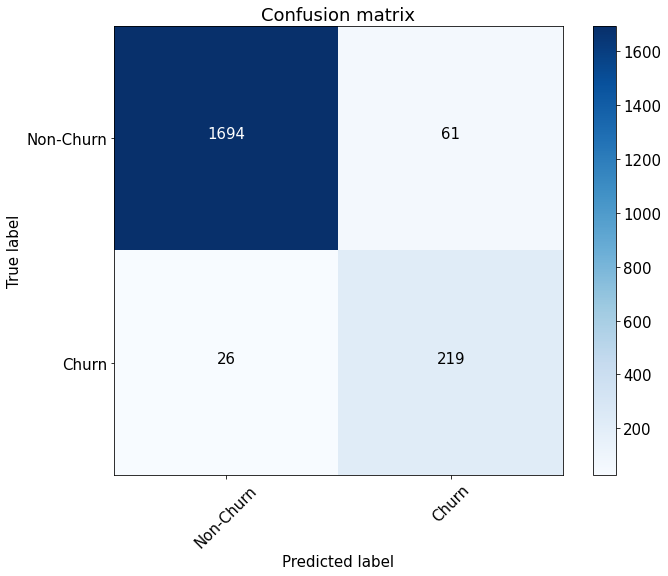

In [22]:
metrics_mean = train_embeddings_and_model(users, churn, get_user_embedding)
metrics_df = pd.DataFrame({key: [value] for key, value in metrics_mean.items()})

In [23]:
metrics_df

,precision,recall,f1_score,roc_auc
0,0.778169,0.902041,0.835539,0.987076


##### Задание 2.1: Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. 

In [27]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # .mean() на .median()
    user_vector = np.median(user_vector, 0)
    return user_vector

##### Задание 2.2. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

F1 score: 0.9352818371607515
ROC-AUC score: 0.9972533286819001


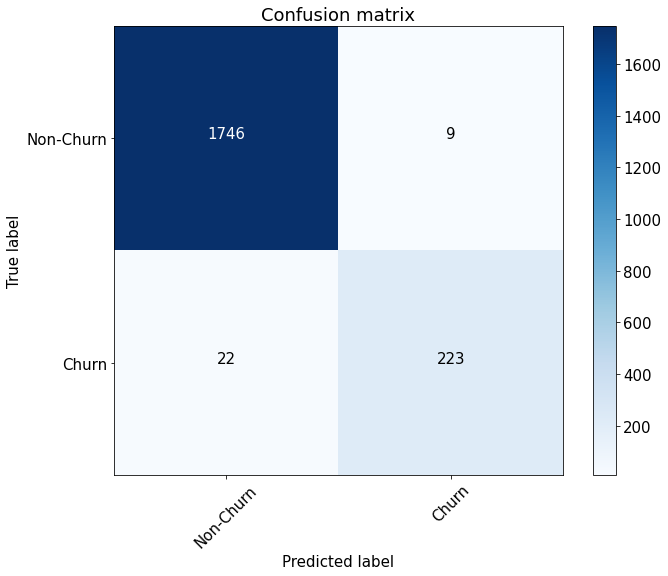

In [28]:
# Сохраняем метрики для user embeddings через .median():

metrics_median = train_embeddings_and_model(users, churn, get_user_embedding_median)
metrics_df = metrics_df.append(metrics_median, ignore_index=True)

In [29]:
metrics_df

,precision,recall,f1_score,roc_auc
0,0.778169,0.902041,0.835539,0.987076
1,0.957265,0.914286,0.935282,0.997253


##### Задание 3: Повторить п.2, но используя уже не медиану, а max

In [30]:
# Меняем .mean() на .max():

def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # .mean() на .max()
    user_vector = np.max(user_vector, 0)
    return user_vector

F1 score: 0.8434237995824634
ROC-AUC score: 0.983379266236409


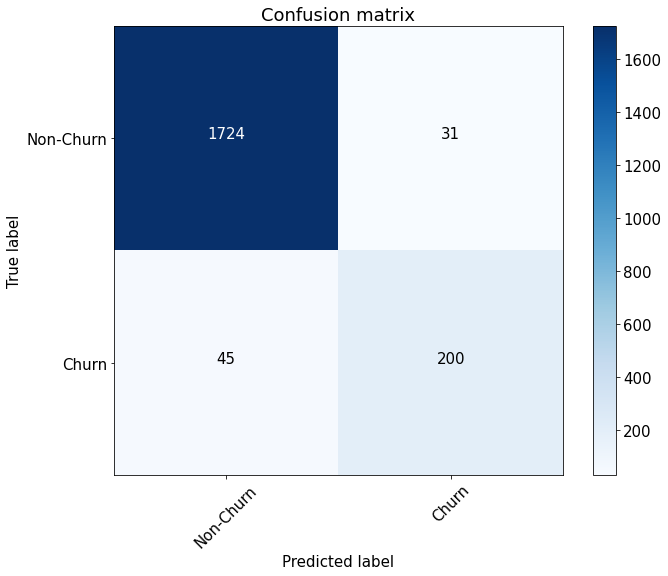

In [31]:
# Сохраняем метрики для user embeddings через .max():

metrics_max = train_embeddings_and_model(users, churn, get_user_embedding_max)
metrics_df = metrics_df.append(metrics_max, ignore_index=True)

In [32]:
metrics_df

,precision,recall,f1_score,roc_auc
0,0.778169,0.902041,0.835539,0.987076
1,0.957265,0.914286,0.935282,0.997253
2,0.863248,0.824490,0.843424,0.983379


##### Задание 4*: Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

In [33]:
# Считаем tf-idf значения для каждого слова в каждом документе:

tfidf_model = TfidfModel(common_corpus)
common_corpus_tfidf = [tfidf_model[doc] for doc in common_corpus]

In [34]:
# Тренируем LDA на tf-idf корпусе:

lda_tfidf = LdaModel(common_corpus_tfidf, num_topics=25, id2word=common_dictionary)#, passes=10)

In [35]:
# Получаем эмбеддинги документов по темам, с учетом подсчета для нового документа значений tf-idf:

def get_lda_vector_tfidf(text):
    unseen_doc = tfidf_model[common_dictionary.doc2bow(text)]
    lda_tuple = lda_tfidf[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [36]:
topic_matrix_tfidf = pd.DataFrame([get_lda_vector_tfidf(text) for text in news['title'].values])
topic_matrix_tfidf.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix_tfidf['doc_id'] = news['doc_id'].values
topic_matrix_tfidf = topic_matrix_tfidf[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
doc_dict = dict(zip(topic_matrix_tfidf['doc_id'].values, topic_matrix_tfidf[['topic_{}'.format(i) for i in range(25)]].values))

F1 score: 0.8046421663442939
ROC-AUC score: 0.9782185010756439


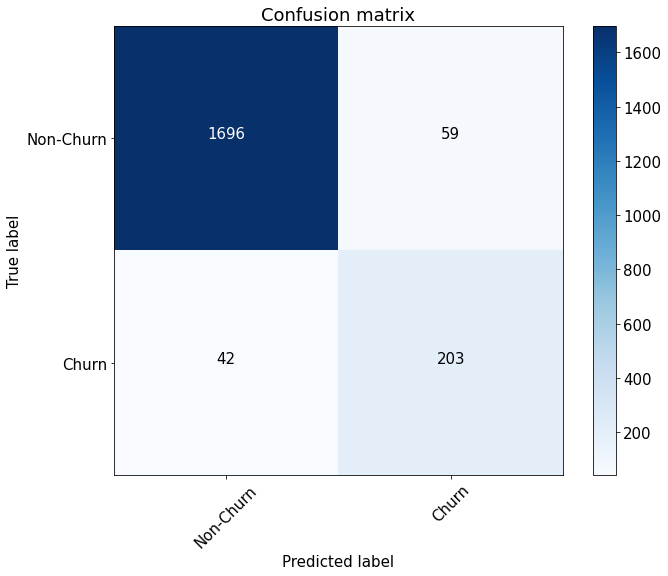

In [37]:
metrics_tfidf = train_embeddings_and_model(users, churn, get_user_embedding)
metrics_df = metrics_df.append(metrics_tfidf, ignore_index=True)

In [38]:
metrics_df.index = ['mean', 'median', 'max', 'idf_mean']

In [39]:
metrics_df

,precision,recall,f1_score,roc_auc
mean,0.778169,0.902041,0.835539,0.987076
median,0.957265,0.914286,0.935282,0.997253
max,0.863248,0.824490,0.843424,0.983379
idf_mean,0.764706,0.848980,0.804642,0.978219


Получение user embeddings по медиане сработало значительно лучше, чем по максимальному значению или среднему (которые показали себя достаточно похоже).

Это произошло потому, что медиана более устойчива к выбросам. Например, пользователь мог случайно посмотреть всего 1 статью с сильной тематикой "экономика", а остальные 20 статей по совершенно другим темам. В таком случае пользователю вряд ли будет интересна именно "экономика". Медиана отражает это лучше, чем среднее или максимальное значение по тематике.

Среднее по tf-idf сработало в некоторой степени противоположно bag-of-words среднему в плане precision и recall - оно начало реже делать ошибки False Negative, но чаще делать ошибки False Positive. В целом tf-idf помог улучшить значения F1-score и ROC-AUC, но они все еще хуже значений медианы и максимального значения для bag-of-words векторизации.

F1 score: 0.7905138339920948
ROC-AUC score: 0.9715936973079831


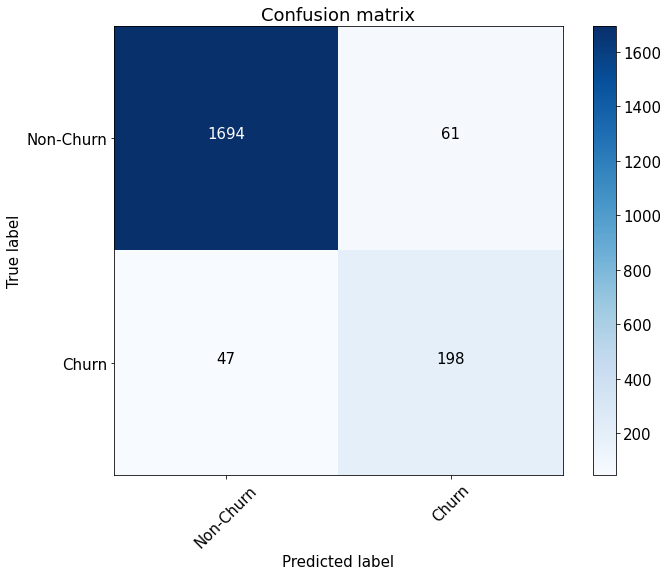

In [41]:
# Найдем user embeddings по tf-idf, но с помощью медианыb:

metrics_tfidf_median = train_embeddings_and_model(users, churn, get_user_embedding_median)
metrics_df = metrics_df.append(metrics_tfidf_median, ignore_index=True)

F1 score: 0.6956521739130435
ROC-AUC score: 0.9438130123844409


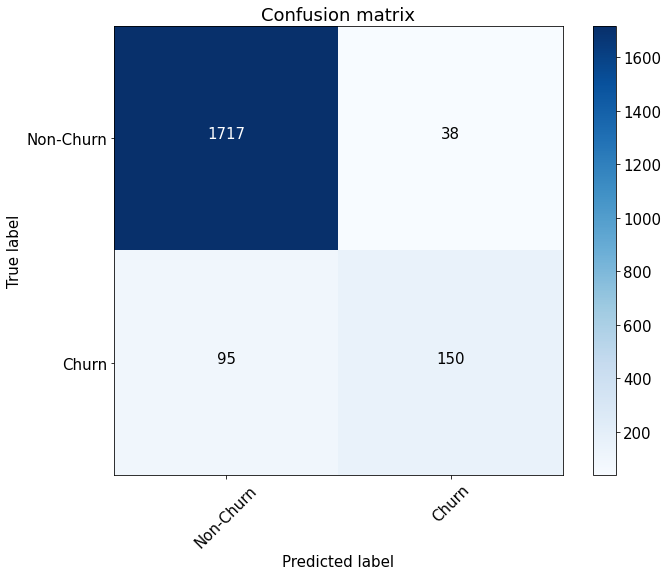

In [42]:
# и максимального значения:

metrics_tfidf_max = train_embeddings_and_model(users, churn, get_user_embedding_max)
metrics_df = metrics_df.append(metrics_tfidf_max, ignore_index=True)

##### Задание 5: Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [43]:
metrics_df.index = ['mean', 'median', 'max', 'idf_mean', 'idf_median', 'idf_max']

metrics_df

,precision,recall,f1_score,roc_auc
mean,0.778169,0.902041,0.835539,0.987076
median,0.957265,0.914286,0.935282,0.997253
max,0.863248,0.824490,0.843424,0.983379
idf_mean,0.764706,0.848980,0.804642,0.978219
idf_median,0.766284,0.816327,0.790514,0.971594
idf_max,0.791667,0.620408,0.695652,0.943813


##### Задание 6: Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Лучшим все так же остался метод нахождения user embeddings с помощью bag-of-words векторизации и медианы.

Метод с tf-idf векторизацией и медианой оказался вторым по F1-score и ROC-AUC. 

Возможно тексты в данном датасете слишком короткие, что ухудшает качество работы tf-idf.